In [123]:
import numpy as np # 导入Numpy
import pandas as pd # 导入Pandas
import os # 导入OS
import cv2 # 导入Open CV工具箱

daisy_dir='./flowers/daisy' #雏菊目录
rose_dir='./flowers/rose' #玫瑰目录
sunflower_dir='./flowers/sunflower' #向日葵目录
tulip_dir='./flowers/tulip' #郁金香目录


X = [] #初始化
y_label = [] #初始化
imgsize = 150 #图片大小
# 定义一个函数读入花的图片
def training_data(label,data_dir):
    print ("正在读入：", data_dir) 
    for img in os.listdir(data_dir): #目录
        path = os.path.join(data_dir,img) #目录+文件名
        img = cv2.imread(path,cv2.IMREAD_COLOR) #读入图片
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(imgsize,imgsize)) #设定图片像素维度
        X.append(np.array(img)) #X特征集
        y_label.append(str(label)) #y标签，即花的类别
# 读入目录中的图片
training_data('daisy',daisy_dir) #读入雏菊
training_data('rose',rose_dir) #读入玫瑰
training_data('sunflower',sunflower_dir) #读入向日葵
training_data('tulip',tulip_dir) #读入郁金香

正在读入： ./flowers/daisy
正在读入： ./flowers/rose
正在读入： ./flowers/sunflower
正在读入： ./flowers/tulip


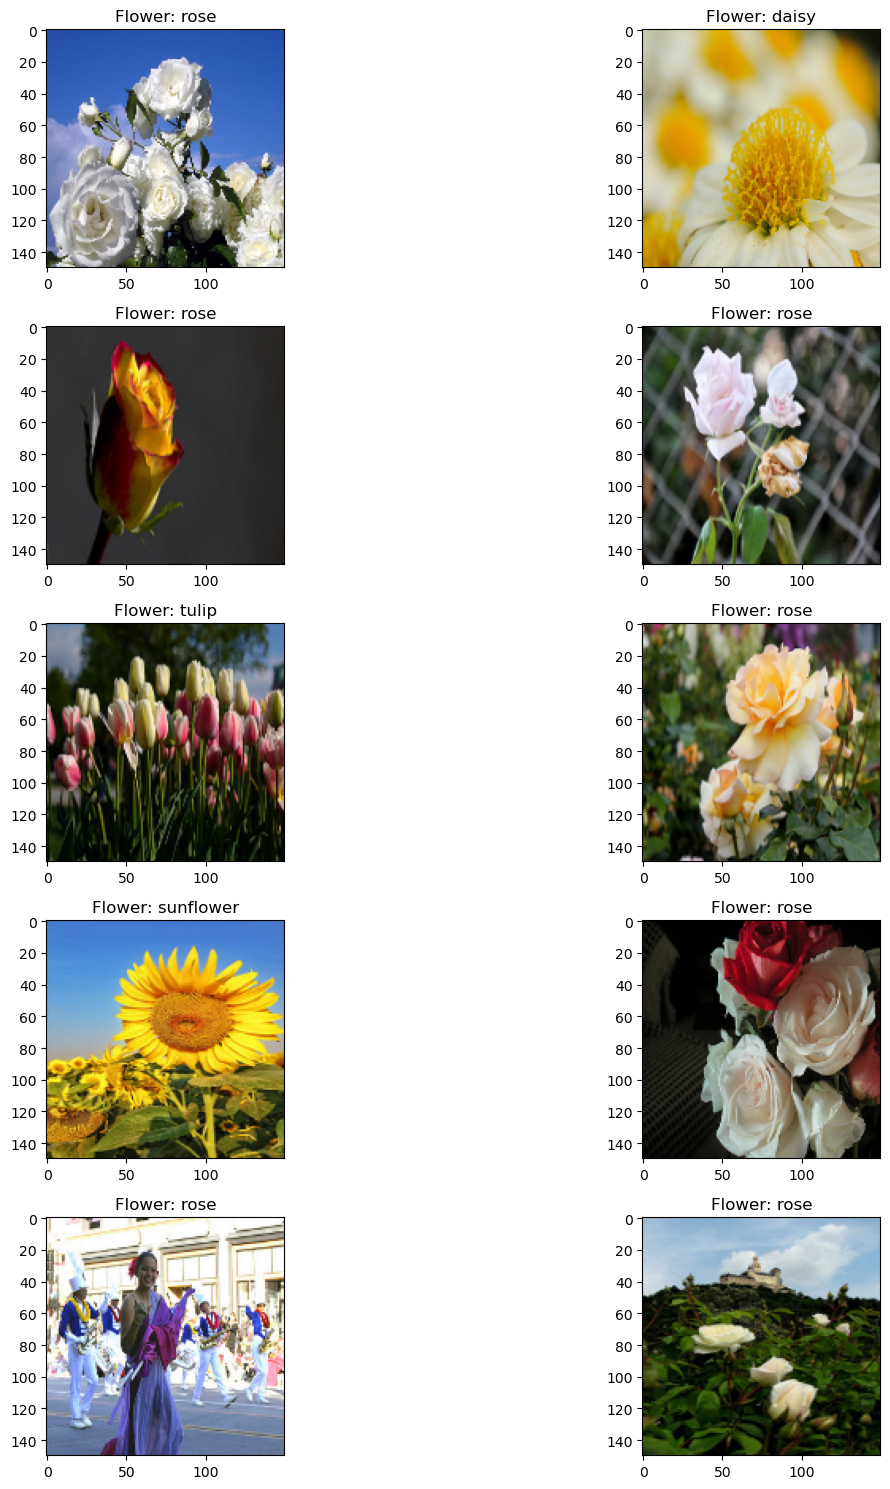

In [124]:
import matplotlib.pyplot as plt # 导入matplotlib
import random as rdm # 导入随机数工具
# 随机显示几张漂亮的花朵图片吧
fig,ax=plt.subplots(5,2) #画布
fig.set_size_inches(15,15) #大小
for i in range(5):
    for j in range (2):
        r=rdm.randint(0,len(X)) #随机选择图片
        ax[i,j].imshow(X[r]) #显示图片
        ax[i,j].set_title('Flower: '+y_label[r]) #花的类别
plt.tight_layout() #绘图

In [125]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
print("可用的 GPU:", devices) 
# 如果输出中有 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]，说明成功了！

可用的 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [126]:
from sklearn.preprocessing import LabelEncoder # 导入标签编码工具
from tensorflow.keras.utils import to_categorical # 导入One-hot编码工具
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label) # 标签编码
y = to_categorical(y,4) # 将标签转换为One-hot编码
X = np.array(X) # 将X从列表转换为张量数组

In [127]:
X = X.astype('float32') / 255.0

In [128]:
from sklearn.model_selection import train_test_split # 导入拆分工具
X_train, X_test, y_train, y_test = train_test_split(X, y, #拆分数据集
                             test_size=0.2,random_state=1)

In [ ]:
from tensorflow.keras import layers # 导入所有层 行1
from tensorflow.keras import models # 导入所有模型 行2
from tensorflow.keras.optimizers import RMSprop # 导入优化器
from tensorflow.keras.optimizers import Adam

# ============ 对照组模型：原始 CNN ============
cnn = models.Sequential()
cnn.add(layers.Input(shape=(150, 150, 3)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(512, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))
cnn.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=1e-4),
            metrics=['acc'])

# ============ 组合模型：数据增强 + BatchNormalization + Dropout ============
cnn_combined = models.Sequential()
cnn_combined.add(layers.Input(shape=(150, 150, 3)))
cnn_combined.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_combined.add(layers.BatchNormalization())  # ✅ 用 BN 替代 Dropout
cnn_combined.add(layers.MaxPooling2D((2, 2)))
cnn_combined.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_combined.add(layers.BatchNormalization())  # ✅ 用 BN 替代 Dropout
cnn_combined.add(layers.MaxPooling2D((2, 2)))
cnn_combined.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_combined.add(layers.BatchNormalization())  # ✅ 用 BN 替代 Dropout
cnn_combined.add(layers.MaxPooling2D((2, 2)))
cnn_combined.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_combined.add(layers.BatchNormalization())  # ✅ 用 BN 替代 Dropout
cnn_combined.add(layers.MaxPooling2D((2, 2)))
cnn_combined.add(layers.Flatten())
cnn_combined.add(layers.Dropout(0.5))  # ✅ 全连接层保留 Dropout
cnn_combined.add(layers.Dense(512, activation='relu'))
cnn_combined.add(layers.Dropout(0.5))  # ✅ 全连接层保留 Dropout
cnn_combined.add(layers.Dense(4, activation='softmax'))
cnn_combined.compile(loss='categorical_crossentropy',
                     optimizer=Adam(learning_rate=1e-4),
                     metrics=['acc'])

print("✓ 已创建三个模型：")
print("  - cnn: 原始模型（对照组）")
print("  - cnn_combined: BatchNormalization + Dropout（配合数据增强使用）")

✓ 已创建三个模型：
  - cnn: 原始模型（对照组）
  - cnn_dropout: 带 Dropout 的模型
  - cnn_combined: BatchNormalization + Dropout（配合数据增强使用）


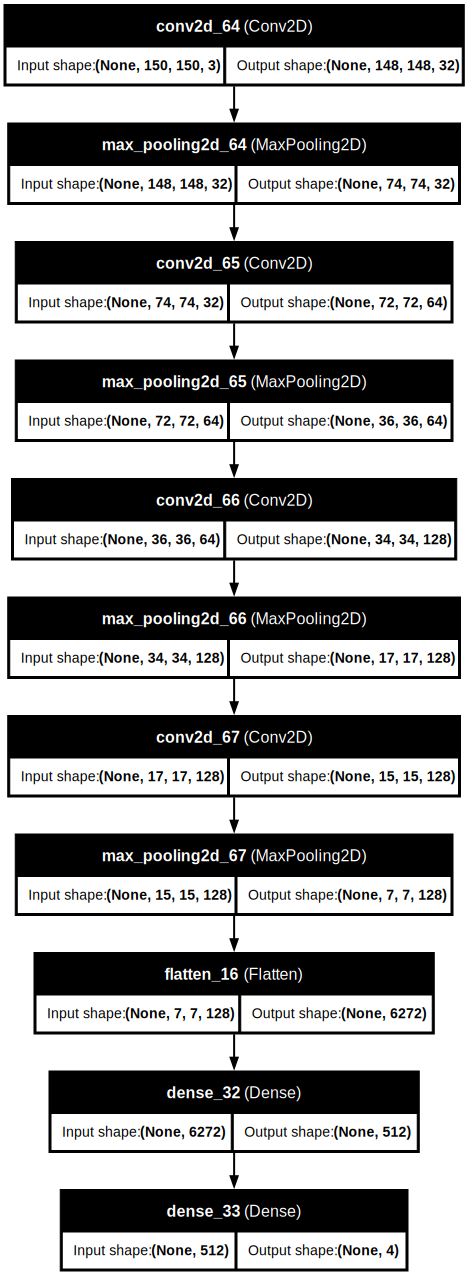

In [130]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

# 这里的 dpi=72 会让图片变小，rankdir='LR' 会让它变扁（横向）
dot = model_to_dot(cnn, show_shapes=True, rankdir='TR', dpi=72)

# 限制显示宽度为 800 像素
display(SVG(dot.create(prog='dot', format='svg')))

```
层	输出尺寸	说明
输入	150×150×3	RGB图像
Conv2D(32)	148×148×32	32个特征图
MaxPool	74×74×32	尺寸减半
Conv2D(64)	72×72×64	64个特征图
MaxPool	36×36×64	尺寸减半
Conv2D(128)	34×34×128	128个特征图
MaxPool	17×17×128	尺寸减半
Conv2D(128)	15×15×128	128个特征图
MaxPool	7×7×128	尺寸减半
```

```
输入图像 (150×150×3)
      ↓
┌─────────────────────┐
│   卷积层 + 池化层     │  提取图像特征
│   (多层堆叠)         │
└─────────────────────┘
      ↓
   (7×7×128 = 6272 个值)
      ↓
┌─────────────────────┐
│  Flatten() 展平层    │  把 7×7×128 的立方体拉成一维向量
└─────────────────────┘
      ↓
   (6272 个值)
      ↓
┌─────────────────────┐
│  Dense(512)         │  6272 → 512（特征压缩与组合）
└─────────────────────┘
      ↓
   (512 个值)
      ↓
┌─────────────────────┐
│  Dense(4, softmax)  │  512 → 4（输出每个类别的概率）
└─────────────────────┘
      ↓
   [0.05, 0.85, 0.03, 0.07]  ← 4个概率值

```

In [131]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss'] #训练损失
    val_loss = history.history['val_loss'] #验证损失
    epochs = range(1, len(loss) + 1) #训练轮次
    plt.figure(figsize=(12,4)) # 图片大小
    plt.subplot(1, 2, 1) #子图1
    plt.plot(epochs, loss, 'bo', label='Training loss') #训练损失
    plt.plot(epochs, val_loss, 'b', label='Validation loss') #验证损失
    plt.title('Training and validation loss') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Loss') #Y轴文字
    plt.legend() #图例
    acc = history.history['acc'] #训练准确率
    val_acc = history.history['val_acc'] #验证准确率
    plt.subplot(1, 2, 2) #子图2
    plt.plot(epochs, acc, 'bo', label='Training acc') #训练准确率
    plt.plot(epochs, val_acc, 'b', label='Validation acc') #验证准确率
    plt.title('Training and validation accuracy') #图题
    plt.xlabel('Epochs') #X轴文字
    plt.ylabel('Accuracy') #Y轴文字
    plt.legend() #图例
    plt.show() #绘图

对照组：不使用数据增强
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - acc: 0.4456 - loss: 1.1900 - val_acc: 0.5804 - val_loss: 1.0116
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.6091 - loss: 0.9104 - val_acc: 0.6080 - val_loss: 0.9462
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.6260 - loss: 0.8695 - val_acc: 0.6248 - val_loss: 0.9491
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.6662 - loss: 0.8141 - val_acc: 0.6539 - val_loss: 0.8740
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.6799 - loss: 0.7682 - val_acc: 0.6279 - val_loss: 0.8866
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.7109 - loss: 0.7209 - val_acc: 0.6646 - val_loss: 0.8457
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - acc: 0.7255 - loss: 0.6885 - val_acc: 0.6279 - val_loss: 0.9546
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - acc: 0.7347 - loss: 0.6752 - val_acc: 0.6708 - val_loss: 0.8479
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step -

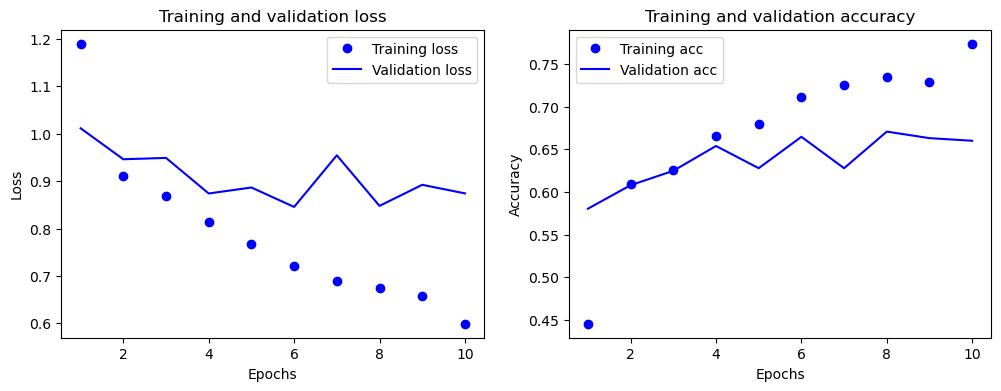


对照组测试准确率: 66.00%


/opt/homebrew/Caskroom/miniforge/base/envs/machine_learning/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [132]:
# ============ 对照组：不使用数据增强 ============
# 先保存当前模型权重，训练完对照组后恢复
cnn.save_weights('cnn_initial_weights.weights.h5')

print("=" * 50)
print("对照组：不使用数据增强")
print("=" * 50)

history_baseline = cnn.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32
)

# 显示对照组学习曲线
show_history(history_baseline)

# 保存对照组结果
baseline_result = cnn.evaluate(X_test, y_test, verbose=0)
print(f"\n对照组测试准确率: {baseline_result[1]*100:.2f}%")

# 恢复初始权重，准备训练实验组
cnn.load_weights('cnn_initial_weights.weights.h5')

实验组：使用数据增强
Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - acc: 0.3725 - loss: 1.3131 - val_acc: 0.5023 - val_loss: 1.1692
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - acc: 0.5356 - loss: 1.0687 - val_acc: 0.5467 - val_loss: 1.0392
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - acc: 0.5482 - loss: 0.9924 - val_acc: 0.6064 - val_loss: 0.9396
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - acc: 0.5881 - loss: 0.9427 - val_acc: 0.6248 - val_loss: 0.9362
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - acc: 0.5995 - loss: 0.9238 - val_acc: 0.6279 - val_loss: 0.9163
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - acc: 0.6340 - loss: 0.8779 - val_acc: 0.6248 - val_loss: 0.9270
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - acc: 0.6198 - loss: 0.8871 - val_acc: 0.6432 - val_loss: 0.9029
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - acc: 0.6436 - loss: 0.8544 - val_acc: 0.6447 - val_loss: 0.8859
Epoch 9/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - 

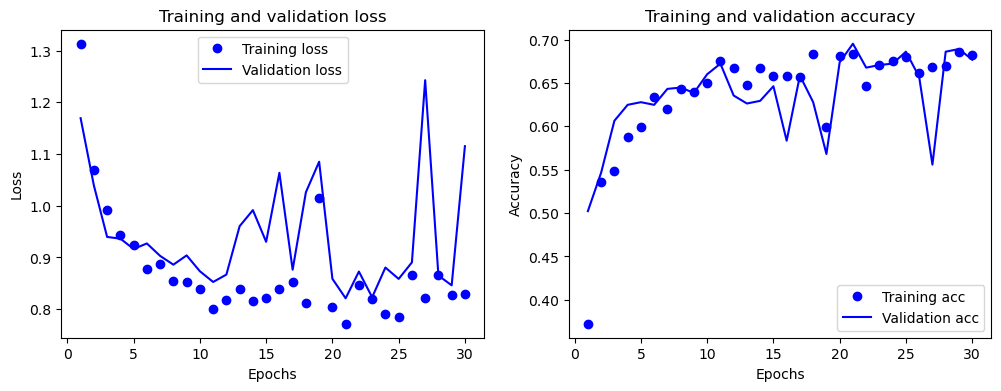


实验组测试准确率: 67.69%


In [133]:
# ============ 实验组：使用数据增强 ============
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("=" * 50)
print("实验组：使用数据增强")
print("=" * 50)

datagen = ImageDataGenerator( #各种增强参数，具体说明可参见Keras文档
           featurewise_center=False,
           samplewise_center=False,         
           featurewise_std_normalization=False,          
           samplewise_std_normalization=False,  
           zca_whitening=False, 
           rotation_range=10,  
           zoom_range = 0.1, 
           width_shift_range=0.2,  
           height_shift_range=0.2,
           horizontal_flip=True,  
           vertical_flip=False
        ) 

# 训练网络并把训练过程信息存入history对象
history_augmented = cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test)
)

# 显示实验组学习曲线
show_history(history_augmented)

# 保存实验组结果
augmented_result = cnn.evaluate(X_test, y_test, verbose=0)
print(f"\n实验组测试准确率: {augmented_result[1]*100:.2f}%")

In [134]:
# ============ 对比结果 ============
print("=" * 50)
print("最终测试集准确率对比")
print("=" * 50)
print(f"对照组（无增强）  : {baseline_result[1]*100:.2f}%")
print(f"数据增强组        : {augmented_result[1]*100:.2f}%")

print("\n" + "-" * 50)
print("相比对照组的提升：")
diff_augmented = (augmented_result[1] - baseline_result[1]) * 100
print(f"数据增强组        : {'+' if diff_augmented > 0 else ''}{diff_augmented:.2f}%")

最终测试集准确率对比
对照组（无增强）  : 66.00%
数据增强组        : 67.69%

--------------------------------------------------
相比对照组的提升：
数据增强组        : +1.68%


In [135]:
prediction = cnn.predict(X_test) #预测测试集的图片分类
prediction[0] #第一张图片的分类

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([2.5993195e-08, 1.6335174e-01, 9.1390662e-05, 8.3655685e-01],
      dtype=float32)

In [136]:
print('第一张测试图片的分类结果为:', np.argmax(prediction[0]))

第一张测试图片的分类结果为: 3
